Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [87]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
import plotnine as p9

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [88]:
df_voles = pd.read_csv('http://bit.ly/2IgDF0E')
df_voles.head()

,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

In [90]:
df_voles['soil'].unique()

array(['moist', 'dry'], dtype=object)

## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

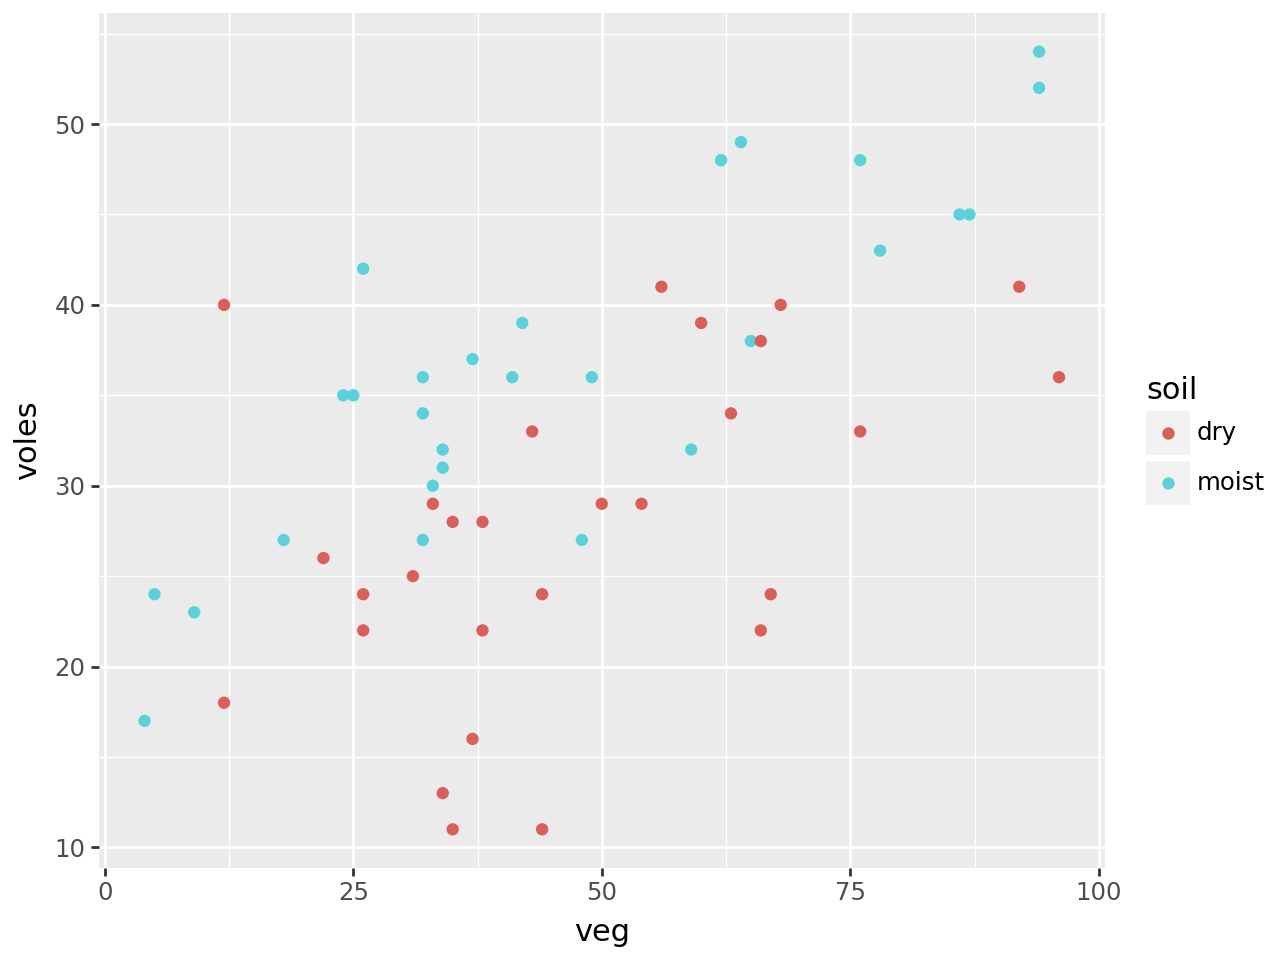

In [94]:
plot = (p9.ggplot(df_voles, p9.aes('veg', 'voles', color='soil'))
        + p9.geom_point())

plot.show()

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

In [95]:
# Make column transformer to dummy encode `soil` and passthrough `veg`
column_transformer = make_column_transformer(
    (OneHotEncoder(drop='first'), ['soil']),
    remainder='passthrough'
)

# Build pipeline with column transformer and sklearn LinearRegression()
pipe = make_pipeline(
    column_transformer,
    LinearRegression()
)

# Define variables and fit pipeline
X = df_voles[['soil', 'veg']]
y = df_voles['voles']

pipe.fit(X, y)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [96]:
def get_regression_table(pipeline):
    terms=list(pipeline['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pipeline['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

In [97]:
reg_table = get_regression_table(pipe)
reg_table

,term,estimate
0,onehotencoder__soil_moist,9.100298
1,remainder__veg,0.259069
2,intercept,15.464026


❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

It appears that prioritizing the protection of high vegetation site would be effective. The coefficient for `remainder veg` is + .259 so the number of voles increase by about 1 for every 4 points increase in vegetation. However, having moist/dry soil is also impactful on our model. The vole estimate was about 9.1 voles higher for moist soil areas. This is about equivalent to a vegetation percentage difference of about 35 points.

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:**

From the chart it appears that at vegetation cover of about 55-60% or higher a majority of the dry sites sustain populations of 30 or more voles. If they want to be more safe I would reccomend ensuring 65% or higher.

In [98]:
# We can use our coefficients to calculate when we would expect 30 voles
# y = mx + b + 0*c  or  30 = 9.100298*(0) + .259069*(?) + 15.464
(30 - reg_table['estimate'][2]) / reg_table['estimate'][1]

56.10851794663282

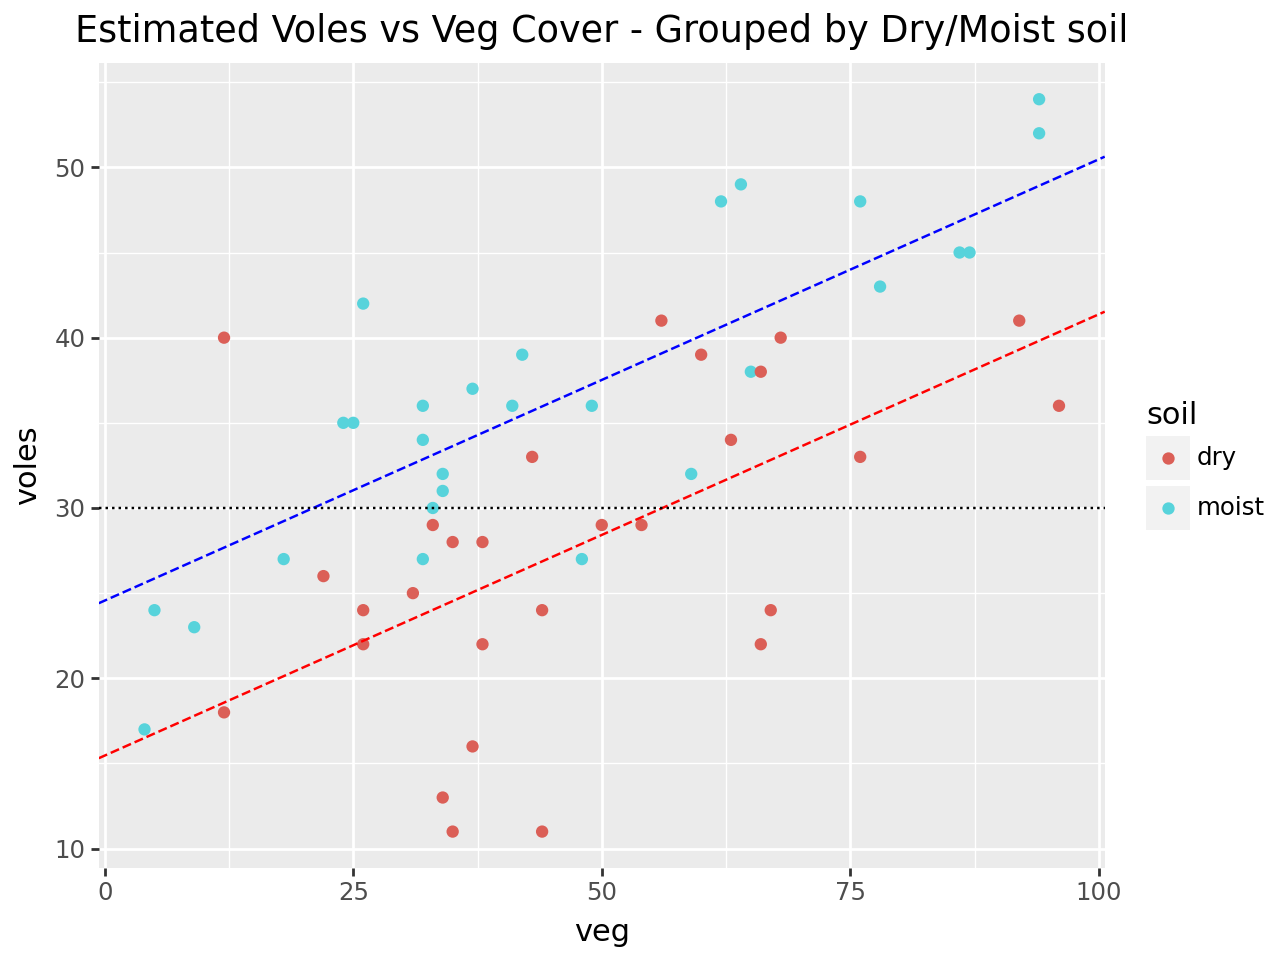

In [99]:
intercept = reg_table['estimate'][2]
slope = reg_table['estimate'][1]
moist = reg_table['estimate'][0]

plot = (p9.ggplot(df_voles, p9.aes('veg', 'voles', color='soil'))
        + p9.geom_point()
        + p9.geom_abline(intercept=intercept, slope=slope, linetype='dashed', color='red', show_legend=True)
        + p9.geom_abline(intercept=intercept + moist, slope=slope, linetype='dashed', color='blue', show_legend=True)
        + p9.geom_hline(yintercept=30, linetype='dotted')
        + p9.theme(legend_position='right')
        + p9.ggtitle('Estimated Voles vs Veg Cover - Grouped by Dry/Moist soil'))
    
plot.show()

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with yout pipeline.)

**Answer:**

In [100]:
pred_array = pipe.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))
print(f'The site with moist soil and 40% vegetation cover might support about {round(pred_array[0],3)} voles')

The site with moist soil and 40% vegetation cover might support about 34.927 voles


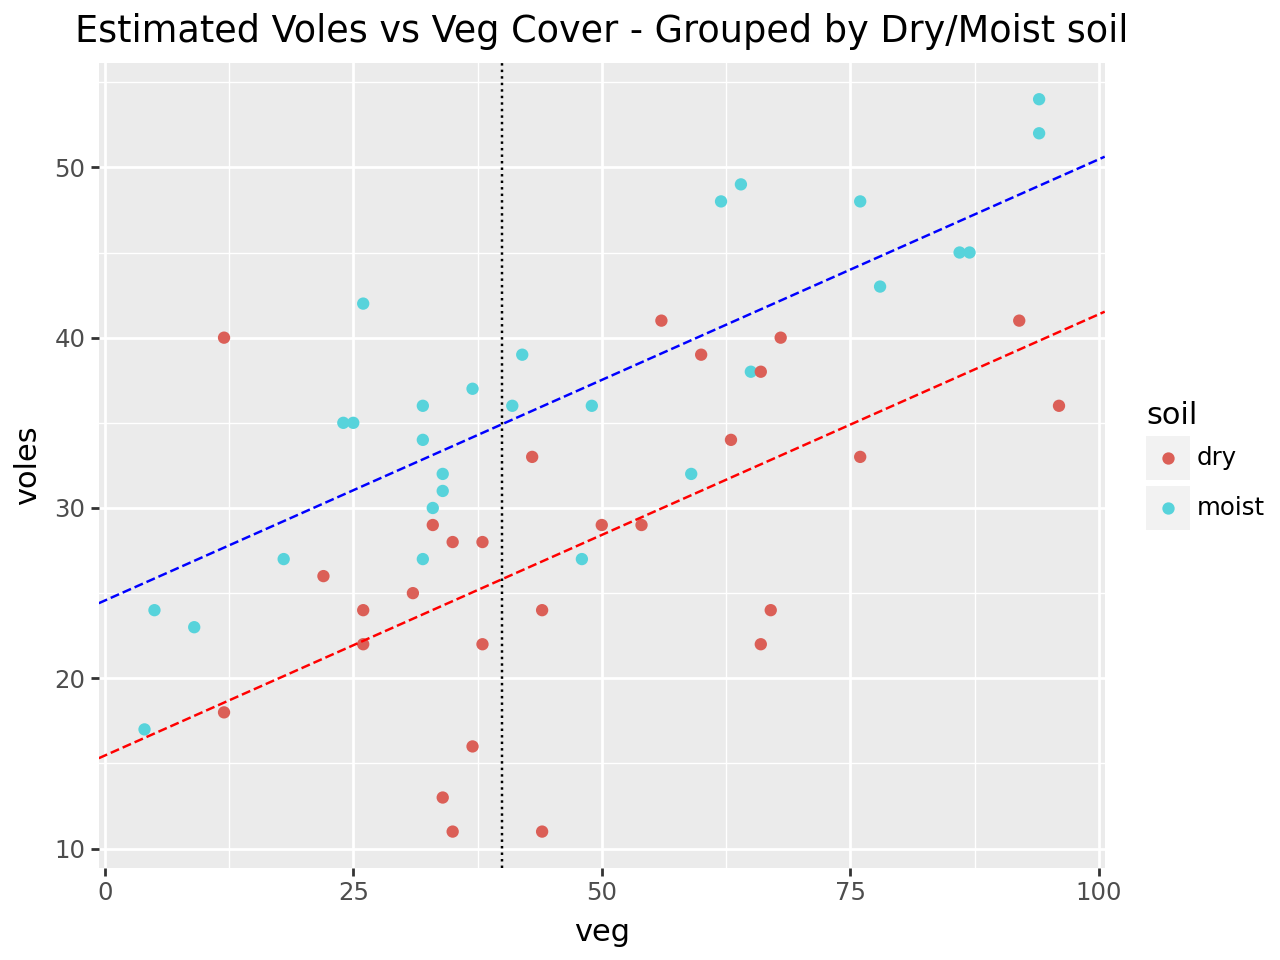

In [101]:
plot = (p9.ggplot(df_voles, p9.aes('veg', 'voles', color='soil'))
        + p9.geom_point()
        + p9.geom_abline(intercept=intercept, slope=slope, linetype='dashed', color='red', show_legend=True)
        + p9.geom_abline(intercept=intercept + moist, slope=slope, linetype='dashed', color='blue', show_legend=True)
        + p9.theme(legend_position='right')
        + p9.ggtitle('Estimated Voles vs Veg Cover - Grouped by Dry/Moist soil')
        + p9.geom_vline(xintercept=40, linetype='dotted'))
    
plot.show()